# On the inclusion times of hubs into the largest connected component under percolation and epidemic processes

[Simon Dobson](mailto:simon.dobson:st-andrews.ac.uk)

### Abstract

Various epidemic processes can be viewed as defining sub-networks according to the occupation of edges, inducing the inclusion of incident nodes. The ways in which these sub-networks form can be important for predicting their growth trajectory, and for the effects that they can have on subsequent processes considered on either the sub-network itself or on the residual network left after the first process completes. We explore the ways in which nodes across the degree distribution are included into the sub-network, focussing especially on the way "hubs" with large degree are included. 

## Inclusion under percolation

In [1]:
import numpy
from pandas import DataFrame, Series
from epyc import ParallelLab, Experiment, LabNotebook, HDF5LabNotebook, RepeatedExperiment
from epydemic import ERNetwork, BANetwork, PLCNetwork, Percolate, StochasticDynamics, BondPercolation, ProcessSequence, NetworkStatistics

# display and interaction
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context('notebook', font_scale=0.75)

In [2]:
# courtesy of https://matplotlib.org/2.1.2/gallery/color/colors_sgskip.html

def pastel(colour, weight=2.4):
    '''Convert colour into a nice pastel shade, for drawing raw
    data as a contrast to averages.
    
    :param colour: the colour
    :param weight: the weight of the pastel
    :returns: a pastel shade of the colour'''
    rgb = numpy.asarray(colors.to_rgba(colour)[:3])
    maxc = max(rgb)
    if maxc < 1.0 and maxc > 0:
        # scale colour
        scale = 1.0 / maxc
        rgb = rgb * scale
    
    # decrease saturation
    total = rgb.sum()
    slack = 0
    for x in rgb:
        slack += 1.0 - x

    # want to increase weight from total to weight
    # pick x s.t.  slack * x == weight - total
    # x = (weight - total) / slack
    x = (weight - total) / slack

    rgb = [c + (x * (1.0 - c)) for c in rgb]

    return rgb

In [3]:
nb = HDF5LabNotebook(name='datasets/first-hitting-times.h5', create=True)
lab = ParallelLab(notebook=nb, cores=8)

In [4]:
class PercolationHittingTimes(Percolate):
    '''A percolation process that captures the first hitting times
    of all degrees in the network.'''
    
    HITTING_TIME = 'hitting-time'    #: Result for hitting times dict.
    
    def __init__(self):
        super().__init__()
        self._hittingTime = dict()
        
    def occupy(self, occupied):
        '''Extract the hitting times. Hitting times are recorded
        as a fraction of the number of edges occupied (first at t = 0,
        last at t = 1).
        
        :param occupied: the edges occupied, in order'''
        super().occupy(occupied)
        g = self.network()
        M = len(occupied)
        kmax = max([d for (_, d) in list(g.degree)])
        self._hittingTime = [-0.0] * (kmax + 1)
        for t in range(len(occupied)):
            (n, m) = occupied[t]
            kn = g.degree[n]
            km = g.degree[m]
            if self._hittingTime[kn] == 0.0:
                self._hittingTime[kn] = t / M
            if self._hittingTime[km] == 0.0:
                self._hittingTime[km] = t / M
                
    def results(self):
        '''Add hitting times to the results.
            
        :returns: the results'''
        rc = super().results()
        rc[self.HITTING_TIME] = self._hittingTime
        return rc

In [5]:
p = ProcessSequence([PercolationHittingTimes(), NetworkStatistics()]) 

In [6]:
if not nb.already('er'):
    nb.current().setDescription('First hitting times as a fraction of nodes added, ER network')
    lab[ERNetwork.N] = 5000
    lab[ERNetwork.KMEAN] = 5
    lab[Percolate.T] = [0.1, 0.2, 0.5, 0.75]
    lab['reps'] = range(100)
    e = StochasticDynamics(p, ERNetwork())
    lab.runExperiment(e)

[('epyc.experiment.classname', '<U'), ('epyc.experiment.elapsed_time', '<f8'), ('epyc.experiment.end_time', '<U'), ('epyc.experiment.exception', '<U'), ('epyc.experiment.experiment_time', '<f8'), ('epyc.experiment.setup_time', '<f8'), ('epyc.experiment.start_time', '<U'), ('epyc.experiment.status', '?'), ('epyc.experiment.teardown_time', '<f8'), ('epyc.experiment.traceback', '<U'), ('epydemic.Dynamics.events', '<i8'), ('epydemic.Dynamics.time', '<i8'), ('epydemic.generators.ER.N', '<i8'), ('epydemic.generators.ER.kmean', '<i8'), ('epydemic.generators.topology', '<U'), ('epydemic.percolate.T', '<f8'), ('reps', '<i8'), ('epydemic.networkstatistics.M', '<i8'), ('epydemic.networkstatistics.N', '<i8'), ('epydemic.networkstatistics.components', '<i8'), ('epydemic.networkstatistics.k_distribution', '<i8', (6,)), ('epydemic.networkstatistics.kmean', '<f8'), ('epydemic.networkstatistics.lcc', '<i8'), ('epydemic.networkstatistics.slcc', '<i8'), ('hitting-time', '<f8', (15,))] [('epyc.experiment.

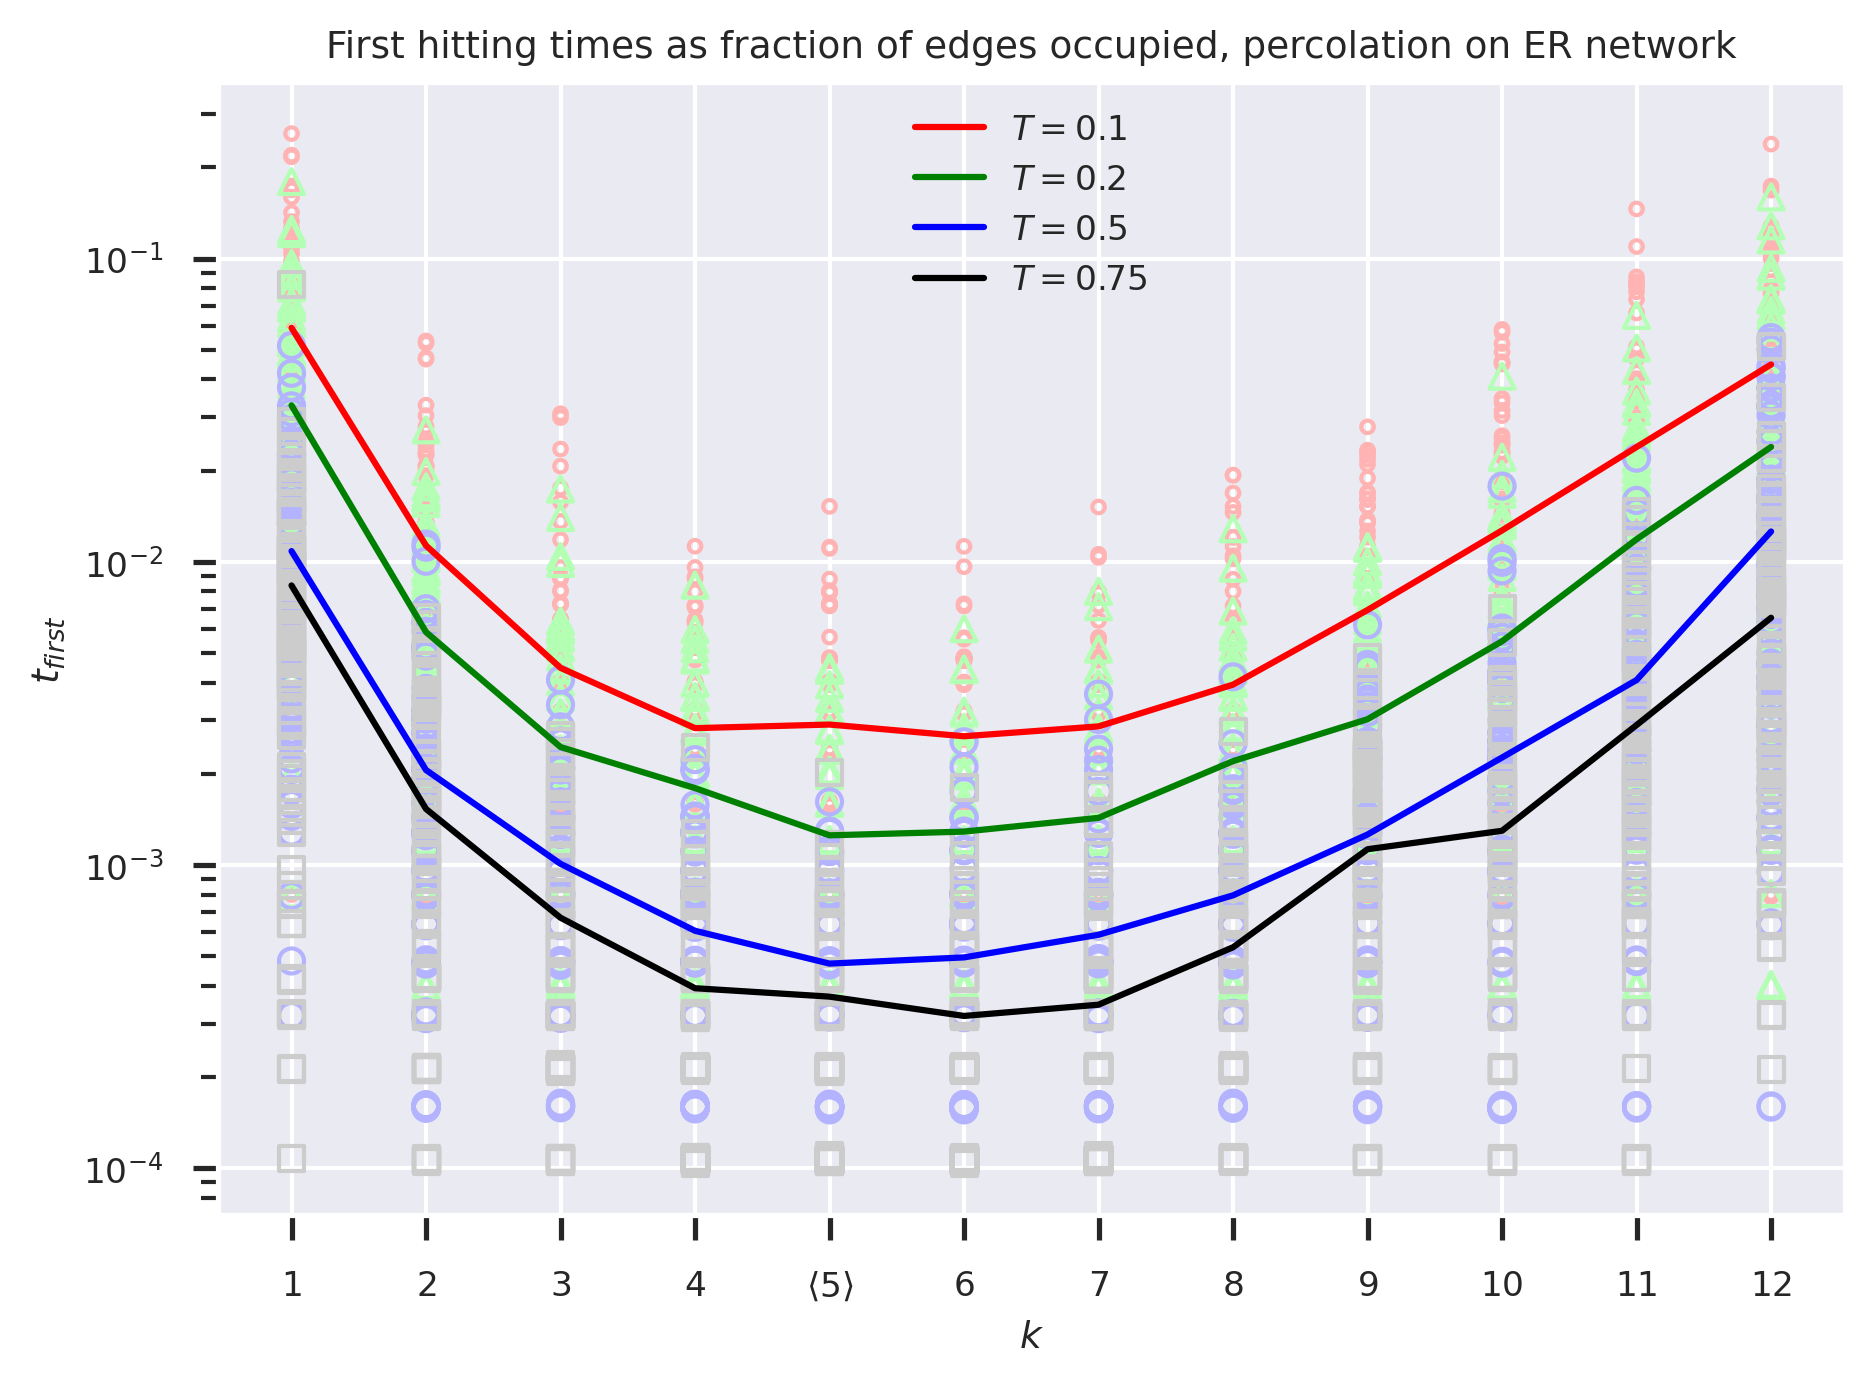

In [7]:
nb.select('er')

df = lab.dataframe()
Ts = df[Percolate.T].unique()

fig = plt.figure(figsize=(7,5))
tColours = ['r', 'g', 'b', 'k']
tMarkers = ['.', '^', 'o', 's']

kmean = int(df[df[Percolate.T] == Ts[0]].loc[0][ERNetwork.KMEAN])
kmax = 13

for i in range(len(Ts)):
    T = Ts[i]
    dft = df[df[Percolate.T] == T]
    hts = dft[PercolationHittingTimes.HITTING_TIME]
    
    # plot raw data
    for ht in hts:
        plt.scatter(list(range(1, kmax)), ht[1:kmax],
                    color='none', edgecolors=pastel(tColours[i]), marker=tMarkers[i])
    
    # plot average for given k
    hta = [0] * kmax
    for ht in hts:
        for l in range(kmax):
            hta[l] += ht[l] / len(hts)
    plt.plot(list(range(1, kmax)), hta[1:kmax],
             color=tColours[i],
             label=f'$T={T}$')
    
plt.xlabel('$k$')
plt.ylabel('$t_{first}$')
plt.xticks(list(range(1, kmax)),
           list(map(lambda k: f'$\\langle {k} \\rangle$' if k == kmean else f'${k}$', range(1, kmax))))
plt.legend(loc='upper center')
plt.yscale('log')
plt.title('First hitting times as fraction of edges occupied, percolation on ER network')

_ = plt.show()

In [8]:
if not nb.already('ba'):
    nb.current().setDescription('First hitting times as a fraction of nodes added, BA network')
    lab.deleteAllParameters()
    lab[BANetwork.N] = 5000
    lab[BANetwork.M] = 3
    lab[Percolate.T] = [0.1, 0.2, 0.5, 0.75]
    lab['reps'] = range(100)
    e = StochasticDynamics(p, BANetwork())
    lab.runExperiment(e)

[('epyc.experiment.classname', '<U'), ('epyc.experiment.elapsed_time', '<f8'), ('epyc.experiment.end_time', '<U'), ('epyc.experiment.exception', '<U'), ('epyc.experiment.experiment_time', '<f8'), ('epyc.experiment.setup_time', '<f8'), ('epyc.experiment.start_time', '<U'), ('epyc.experiment.status', '?'), ('epyc.experiment.teardown_time', '<f8'), ('epyc.experiment.traceback', '<U'), ('epydemic.Dynamics.events', '<i8'), ('epydemic.Dynamics.time', '<i8'), ('epydemic.generators.BA.M', '<i8'), ('epydemic.generators.BA.N', '<i8'), ('epydemic.generators.topology', '<U'), ('epydemic.percolate.T', '<f8'), ('reps', '<i8'), ('epydemic.networkstatistics.M', '<i8'), ('epydemic.networkstatistics.N', '<i8'), ('epydemic.networkstatistics.components', '<i8'), ('epydemic.networkstatistics.k_distribution', '<i8', (29,)), ('epydemic.networkstatistics.kmean', '<f8'), ('epydemic.networkstatistics.lcc', '<i8'), ('epydemic.networkstatistics.slcc', '<i8'), ('hitting-time', '<f8', (234,))] [('epyc.experiment.cl

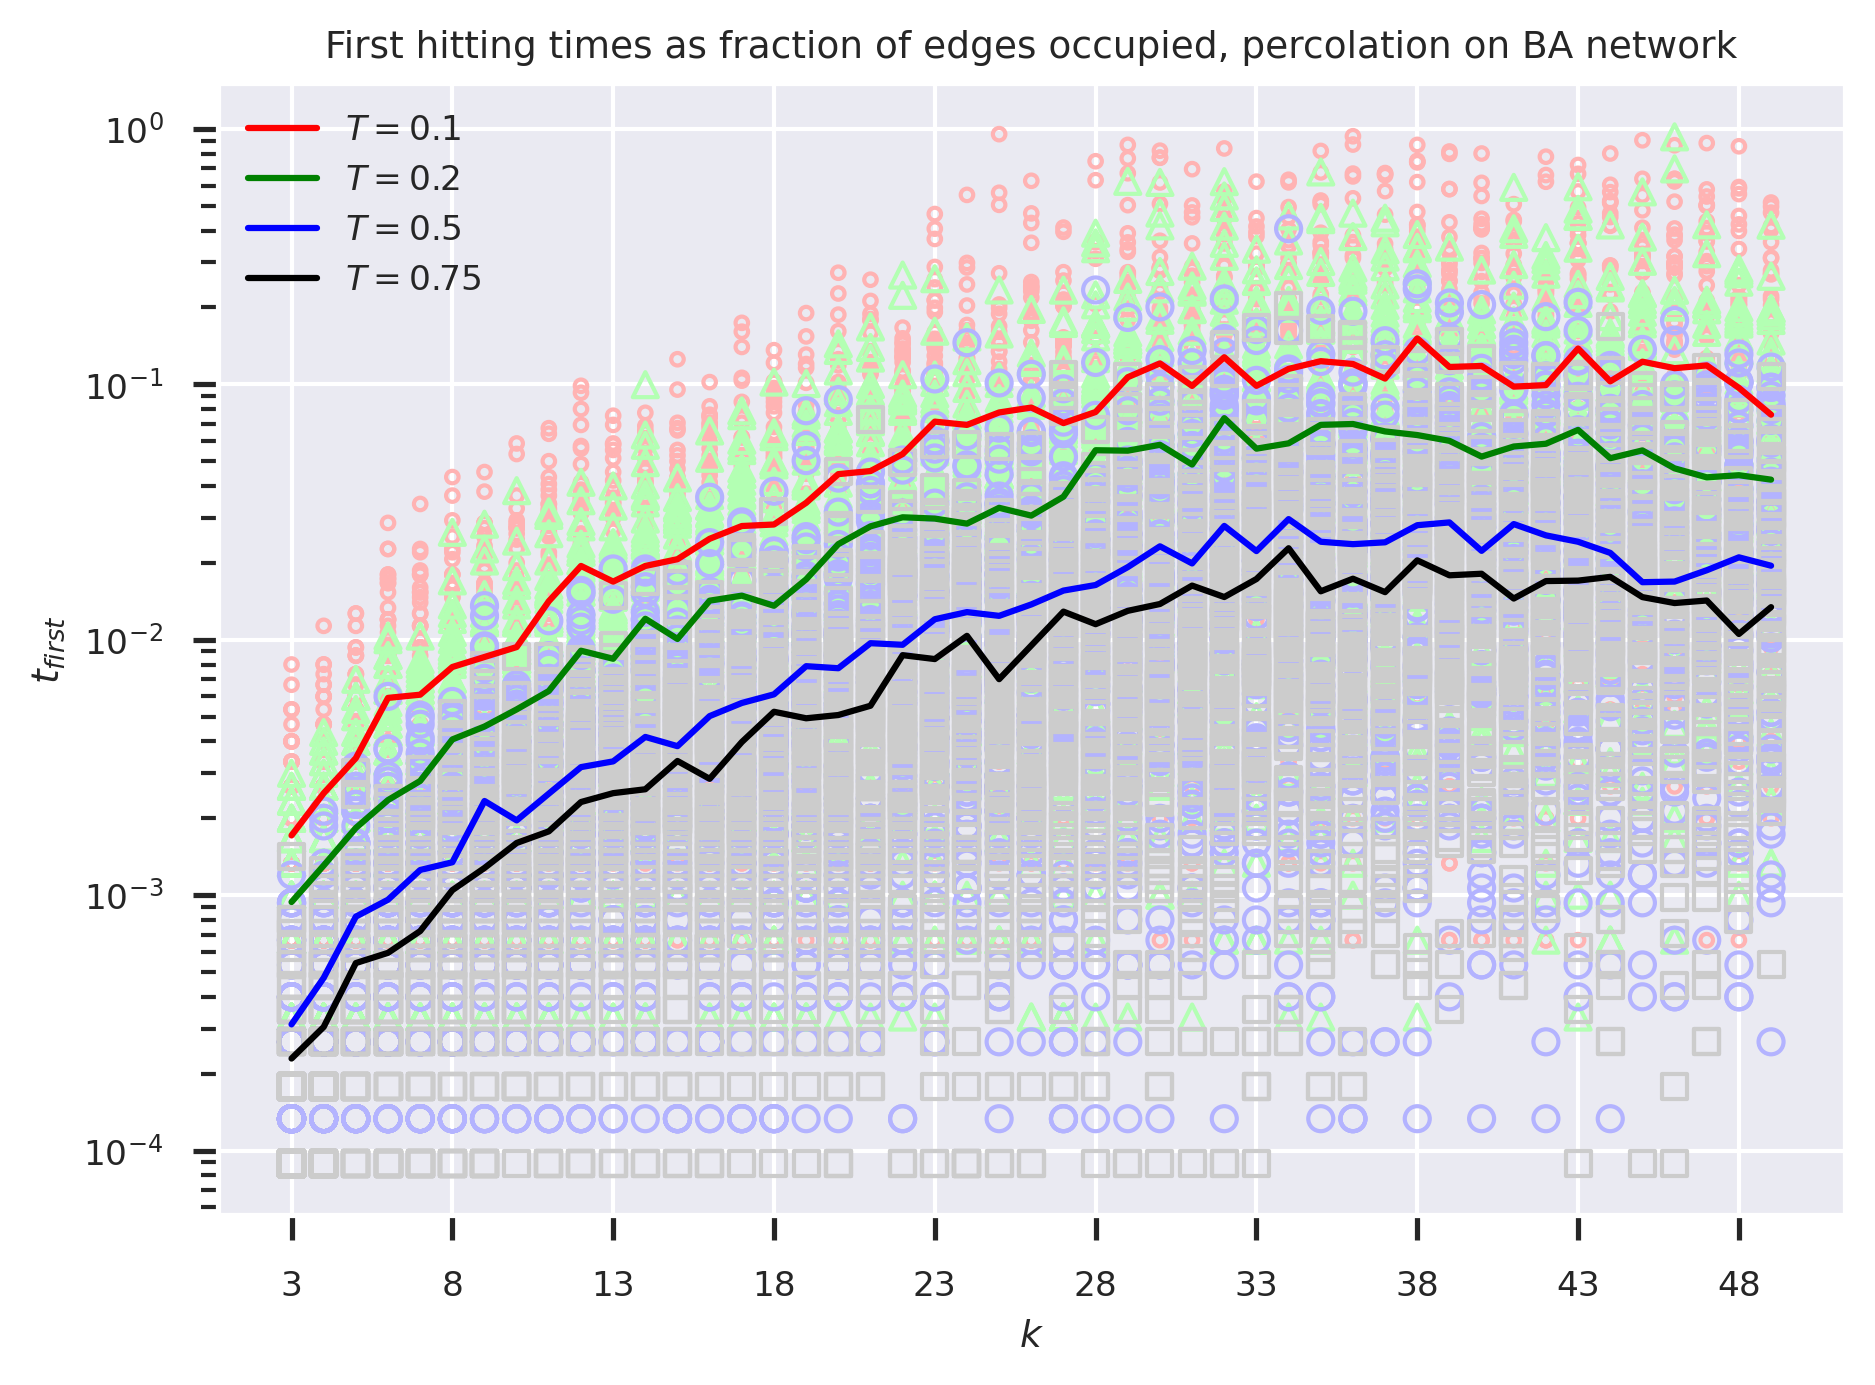

In [9]:
nb.select('ba')

df = lab.dataframe()
Ts = df[Percolate.T].unique()

fig = plt.figure(figsize=(7,5))
tColours = ['r', 'g', 'b', 'k']
tMarkers = ['.', '^', 'o', 's']

kmax = 50
for i in range(len(Ts)):
    T = Ts[i]
    dft = df[df[Percolate.T] == T]
    hts = dft[PercolationHittingTimes.HITTING_TIME]
    
    # plot raw data
    for ht in hts:
        plt.scatter(list(range(3, kmax)), ht[3:kmax],
                    color='none', edgecolors=pastel(tColours[i]), marker=tMarkers[i])
    
    # plot average for given k
    hta = [0] * kmax
    for ht in hts:
        for l in range(kmax):
            hta[l] += ht[l] / len(hts)
    plt.plot(list(range(3, kmax)), hta[3:kmax],
             color=tColours[i],
             label=f'$T={T}$')
    
plt.xlabel('$k$')
plt.ylabel('$t_{first}$')
plt.xticks(list(range(3, kmax, 5)))
plt.legend(loc='upper left')
plt.yscale('log')
plt.title('First hitting times as fraction of edges occupied, percolation on BA network')

_ = plt.show()

## Analytical approach

In [41]:
def make_hitting(k, T, M, Mk):
    
    def Fk(t):
        acc = (1 - T * (Mk / M))
        for l in range(t - 1):
            acc *= (1 - T * (Mk / (M - l)))
        return acc
        
    return Pk

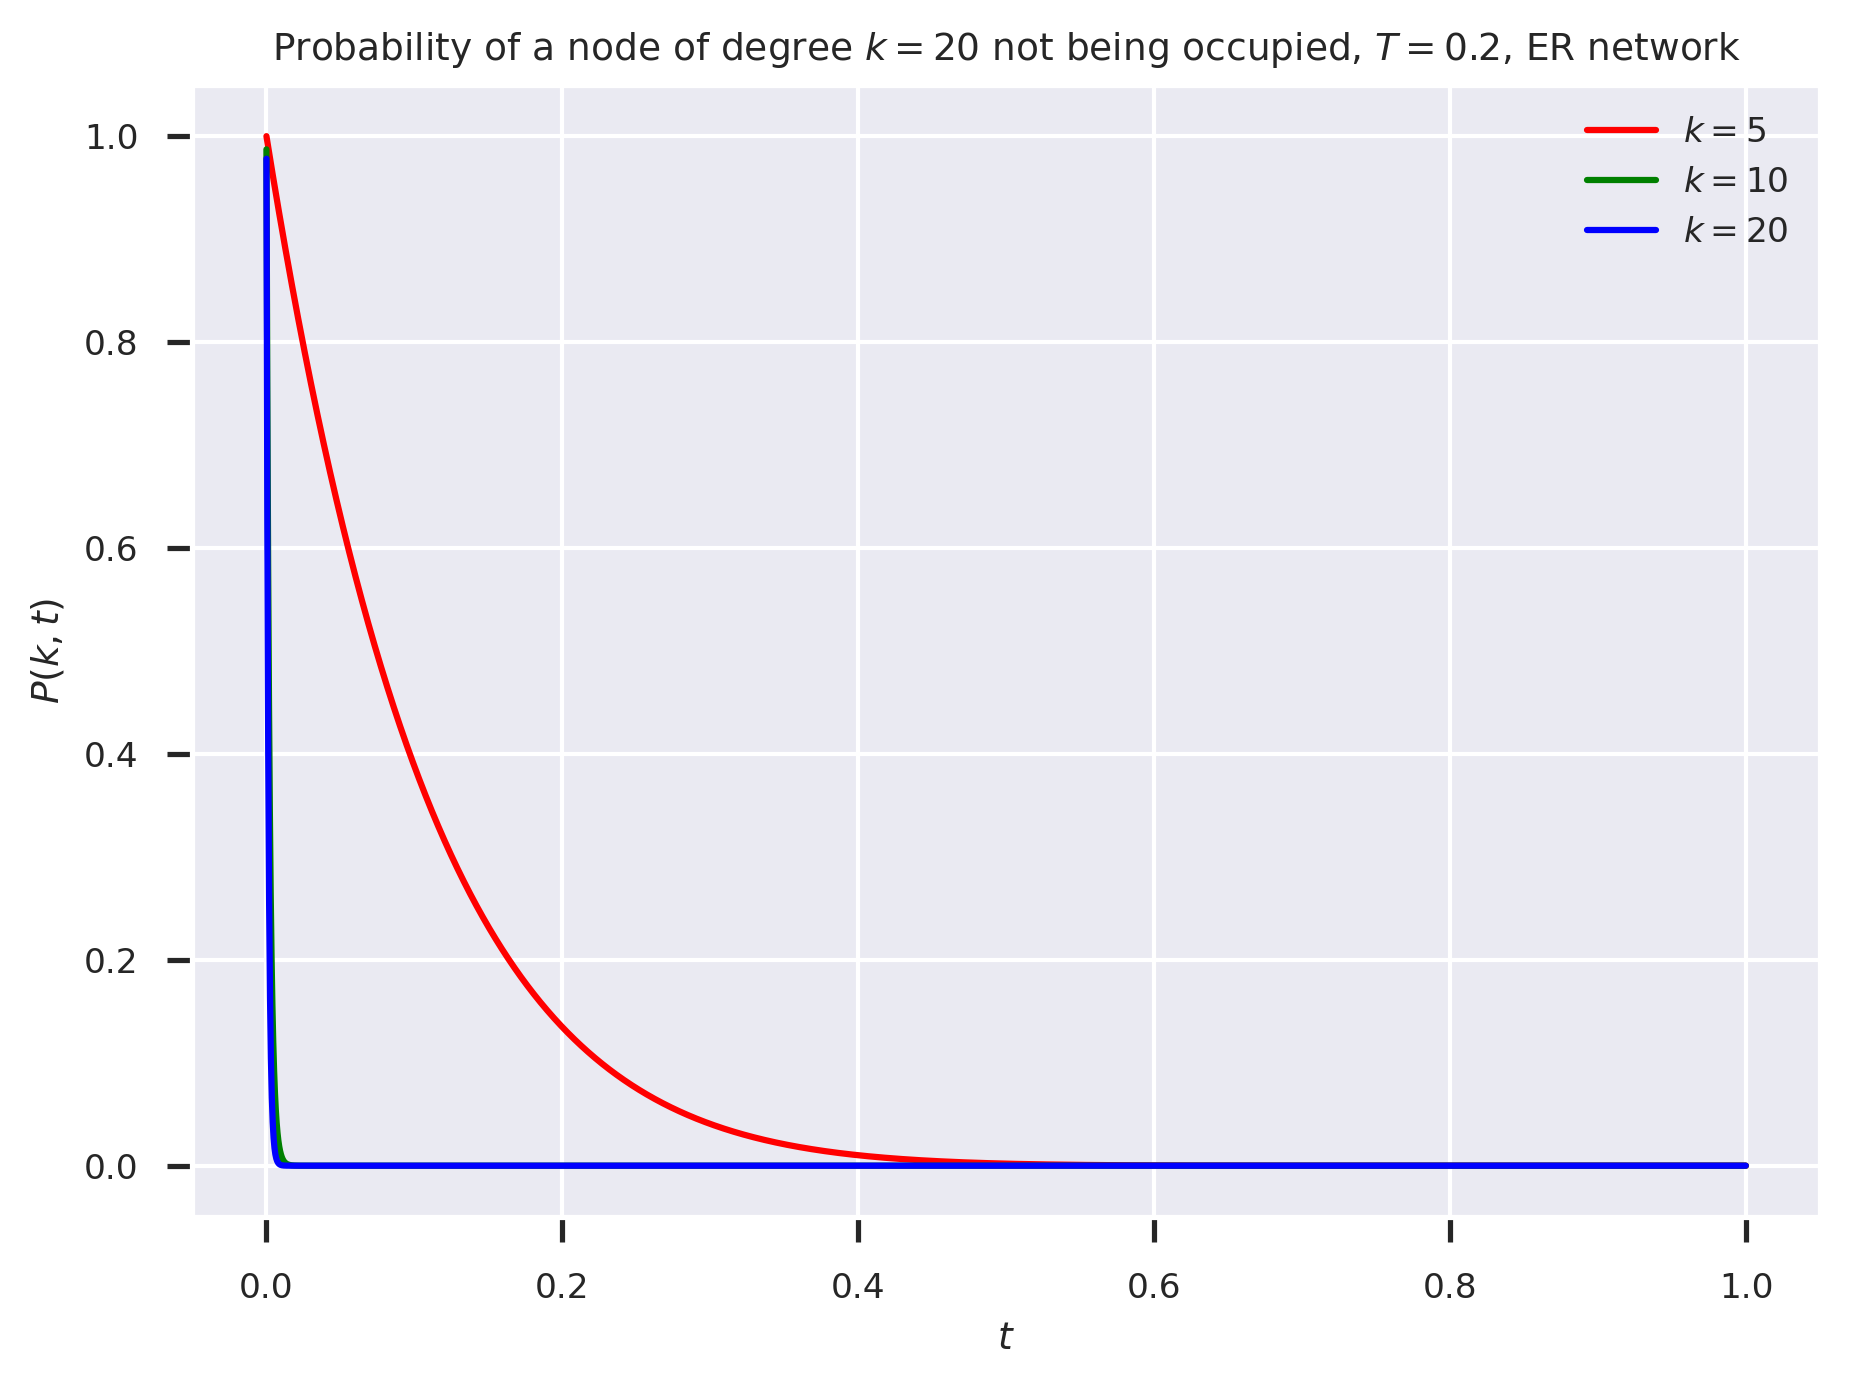

In [15]:
fig = plt.figure(figsize=(7,5))
kColours = ['r', 'g', 'b', 'k']
kMarkers = ['.', '^', 'o', 's']

params = dict()
params[ERNetwork.N] = 5000
params[ERNetwork.KMEAN] = 15
g = ERNetwork().set(params).generate()

T= 0.2
M = len(g.edges)
ks = [5, 10, 20]
for i in range(len(ks)):
    k = ks[i]   
    Nk = len([n for (n, d) in list(g.degree) if d == k]) 
    Mk = k * Nk 
    
    Fk = make_hitting(k, T, M, Mk)

    ts = numpy.array(list(range(1, M - Mk, 10)))
    fs = ts / (M - Mk)
    plt.plot(fs, list(map(Fk, ts)),
             color=kColours[i],
             label=f'$k = {k}$')
        
plt.xlabel('$t$')
plt.ylabel('$P(k, t)$')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.title(f'Probability of a node of degree $k = {k}$ not being occupied, $T = {T}$, ER network')

_ = plt.show()

5 483.6450967354599
10 483.6450967354599
30 483.6450967354599


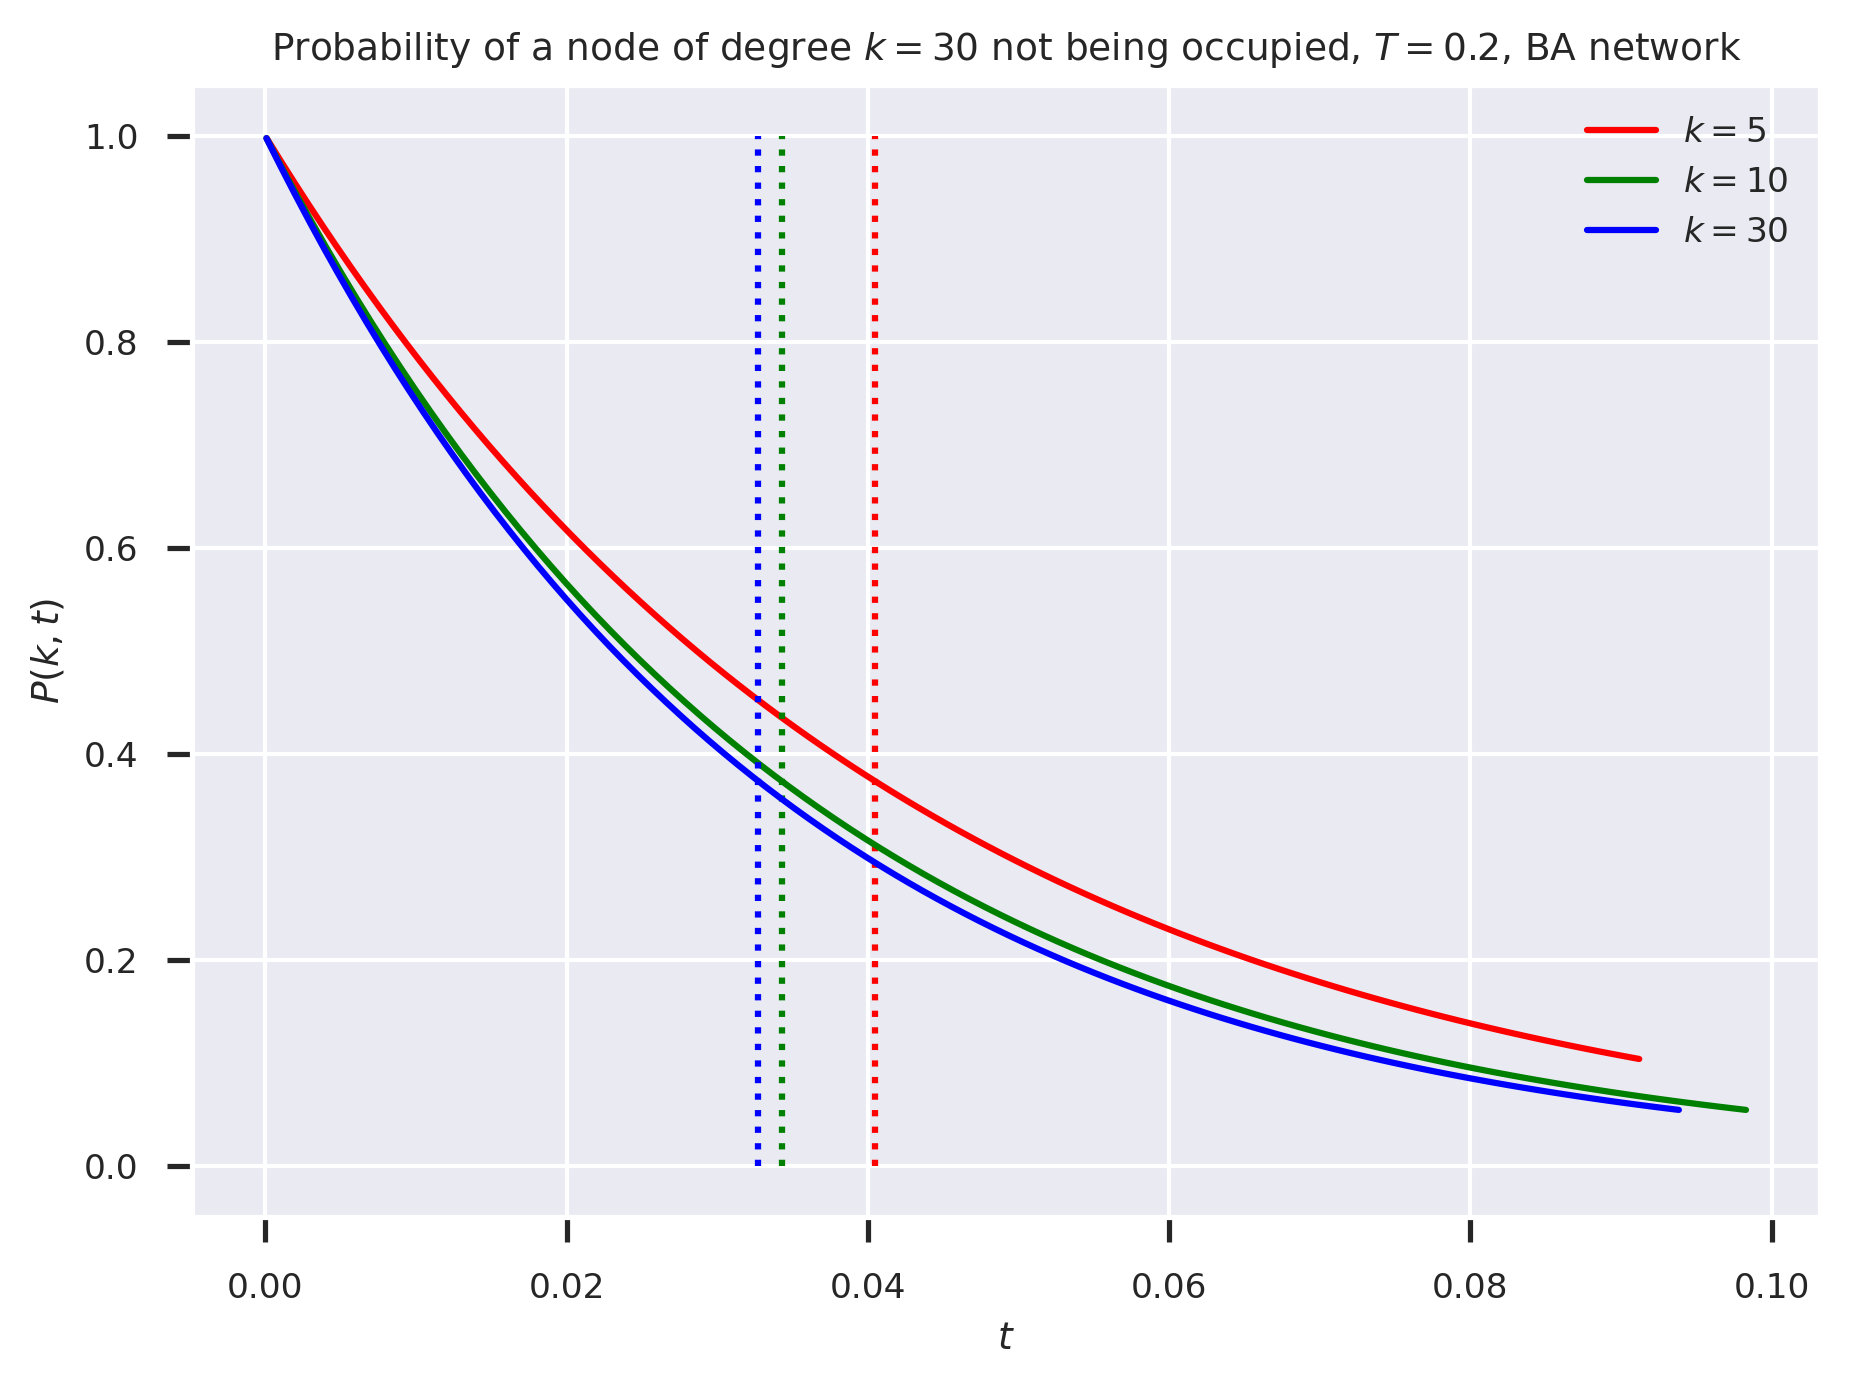

In [43]:
fig = plt.figure(figsize=(7,5))
kColours = ['r', 'g', 'b', 'k']
kMarkers = ['.', '^', 'o', 's']

params = dict()
params[BANetwork.N] = 5000
params[BANetwork.M] = 3
g = BANetwork().set(params).generate()

T= 0.2
M = len(g.edges)
ks = [5, 10, 30]
for i in range(len(ks)):
    k = ks[i]   
    Nk = len([n for (n, d) in list(g.degree) if d == k]) 
    Mk = k * Nk 
    
    Fk = make_hitting(k, T, M, Mk)

    steps = 1000
    tmax = int(steps * 0.1)
    ts = numpy.array(list(range(1, M - Mk, int((M - Mk) / steps))))
    fs = ts / (M - Mk)
    plt.plot(fs[:tmax], list(map(Fk, ts[:tmax])),
             color=kColours[i],
             label=f'$k = {k}$')
        
    cum = 0.0
    v = 0.0
    for t in range(1, M - Mk):
        w = 1 - Fk(t)
        cum += t * (w - v)
        v = w
    print(k, cum)
    plt.plot([cum / (M - Mk)] * 2, [0.0, 1.0], 
             color=kColours[i], linestyle='dotted')
    
plt.xlabel('$t$')
plt.ylabel('$P(k, t)$')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.title(f'Probability of a node of degree $k = {k}$ not being occupied, $T = {T}$, BA network')

_ = plt.show()